In [60]:
import numpy as np # Lineare Algebra
import pandas as pd # Zur Verarbeitung der Daten
import matplotlib.pyplot as plt # Zum Plotten der Funktionen
plt.style.use('fivethirtyeight')

import seaborn as sns # Ergänzung zum Plotten; spezifischere Daten
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [61]:
weather_df = pd.read_csv('delphi_conditions.csv', parse_dates=['datetime_utc'], index_col='datetime_utc')
weather_df.head()

,_conds,_dewptm,_fog,_hail,_heatindexm,_hum,_precipm,_pressurem,_rain,_snow,_tempm,_thunder,_tornado,_vism,_wdird,_wdire,_wgustm,_windchillm,_wspdm
datetime_utc,,,,,,,,,,,,,,,,,,,
1996-11-01 11:00:00,Smoke,9.0,0,0,NaN,27.0,NaN,1010.0,0,0,30.0,0,0,5.0,280.0,West,NaN,NaN,7.4
1996-11-01 12:00:00,Smoke,10.0,0,0,NaN,32.0,NaN,-9999.0,0,0,28.0,0,0,NaN,0.0,North,NaN,NaN,NaN
1996-11-01 13:00:00,Smoke,11.0,0,0,NaN,44.0,NaN,-9999.0,0,0,24.0,0,0,NaN,0.0,North,NaN,NaN,NaN
1996-11-01 14:00:00,Smoke,10.0,0,0,NaN,41.0,NaN,1010.0,0,0,24.0,0,0,2.0,0.0,North,NaN,NaN,NaN
1996-11-01 16:00:00,Smoke,11.0,0,0,NaN,47.0,NaN,1011.0,0,0,23.0,0,0,1.2,0.0,North,NaN,NaN,0.0


In [ ]:
# Feature Engineering: Wir wählen drei Spalten aus, die eine hohe Aussagekraft haben - hier gebe ich sie vor :) 

In [62]:
weather_df = weather_df.loc[:,[' _conds', ' _hum', ' _tempm']]
weather_df = weather_df.rename(index=str, columns={' _conds': 'condition', ' _hum': 'humidity', ' _pressurem': 'pressure', ' _tempm': 'temprature'})
print(f'dataset shape (rows, columns) - {weather_df.shape}')
weather_df.head()

dataset shape (rows, columns) - (100990, 3)


,condition,humidity,temprature
datetime_utc,,,
1996-11-01 11:00:00,Smoke,27.0,30.0
1996-11-01 12:00:00,Smoke,32.0,28.0
1996-11-01 13:00:00,Smoke,44.0,24.0
1996-11-01 14:00:00,Smoke,41.0,24.0
1996-11-01 16:00:00,Smoke,47.0,23.0


In [63]:
weather_df.dtypes, weather_df.index.dtype

(condition      object
 humidity      float64
 temprature    float64
 dtype: object,
 dtype('O'))

In [64]:
weather_df.index = pd.to_datetime(weather_df.index)
weather_df.index

DatetimeIndex(['1996-11-01 11:00:00', '1996-11-01 12:00:00',
               '1996-11-01 13:00:00', '1996-11-01 14:00:00',
               '1996-11-01 16:00:00', '1996-11-01 17:00:00',
               '1996-11-01 18:00:00', '1996-11-01 19:00:00',
               '1996-11-01 20:00:00', '1996-11-01 21:00:00',
               ...
               '2017-04-23 15:00:00', '2017-04-23 18:00:00',
               '2017-04-23 21:00:00', '2017-04-24 00:00:00',
               '2017-04-24 03:00:00', '2017-04-24 06:00:00',
               '2017-04-24 09:00:00', '2017-04-24 12:00:00',
               '2017-04-24 15:00:00', '2017-04-24 18:00:00'],
              dtype='datetime64[ns]', name='datetime_utc', length=100990, freq=None)

In [ ]:
# Data Cleaning - wie geht man mit Missing Values um?
# Missing Values
# was machen wir in der nachfolgenden Funktion mit den (wenigen) Missing values?

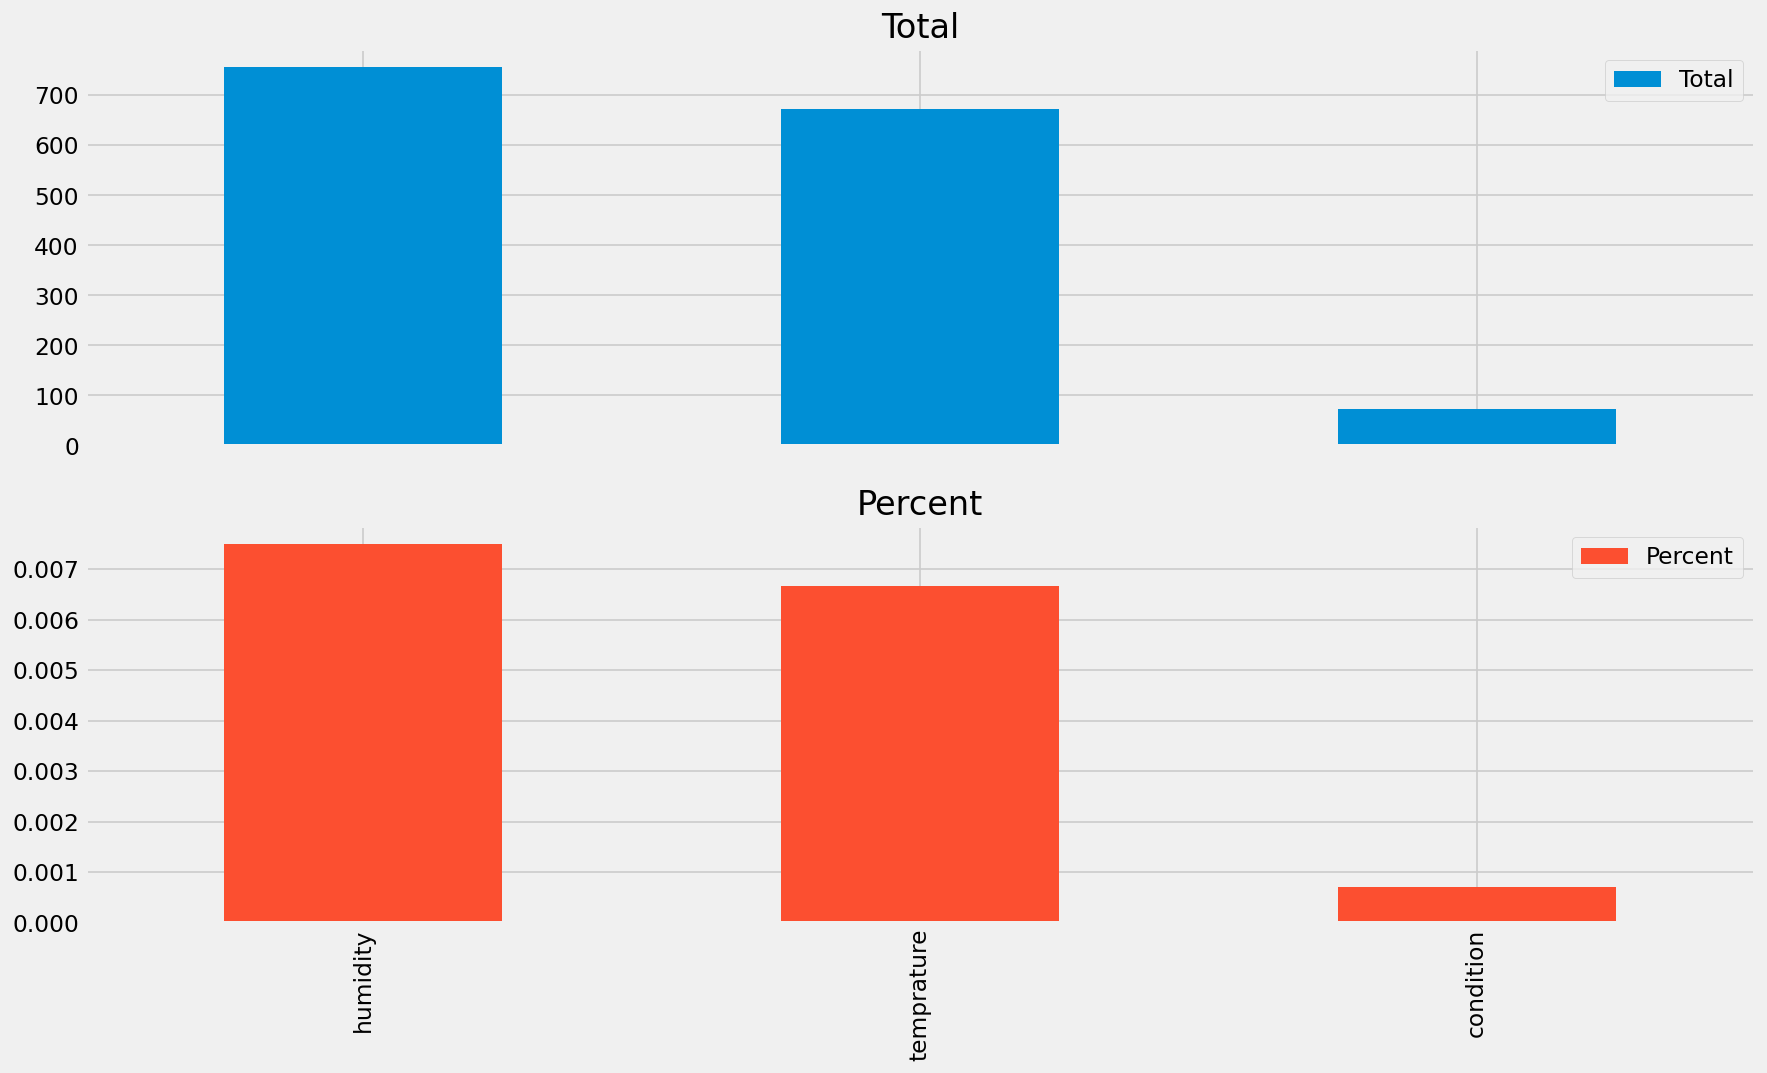

In [65]:
def list_and_visualize_missing_data(dataset):
    # Listing total null items and its percent with respect to all nulls
    total = dataset.isnull().sum().sort_values(ascending=False)
    percent = ((dataset.isnull().sum())/(dataset.isnull().count())).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    missing_data = missing_data[missing_data.Total > 0]
    
    missing_data.plot.bar(subplots=True, figsize=(16,9))

list_and_visualize_missing_data(weather_df)

In [66]:
weather_df.ffill(inplace=True)
weather_df[weather_df.isnull()].count()

condition     0
humidity      0
temprature    0
dtype: int64

In [ ]:
# Data Understanding - wie sieht die Datenverteilung bzw. die Wertespanne aus? Ausreißer identifizieren und löschen

In [67]:
weather_df.describe()

,humidity,temprature
count,100990.000000,100990.000000
mean,57.957422,25.438222
std,23.821218,8.487994
min,4.000000,1.000000
25%,39.000000,19.000000
50%,59.000000,27.000000
75%,78.000000,32.000000
max,243.000000,90.000000


In [68]:
weather_df = weather_df[weather_df.temprature < 50]
weather_df = weather_df[weather_df.humidity <= 100]

In [ ]:
# Exploratory Data Analysis (EDA) & Visualisierung

Text(0, 0.5, 'Percent')

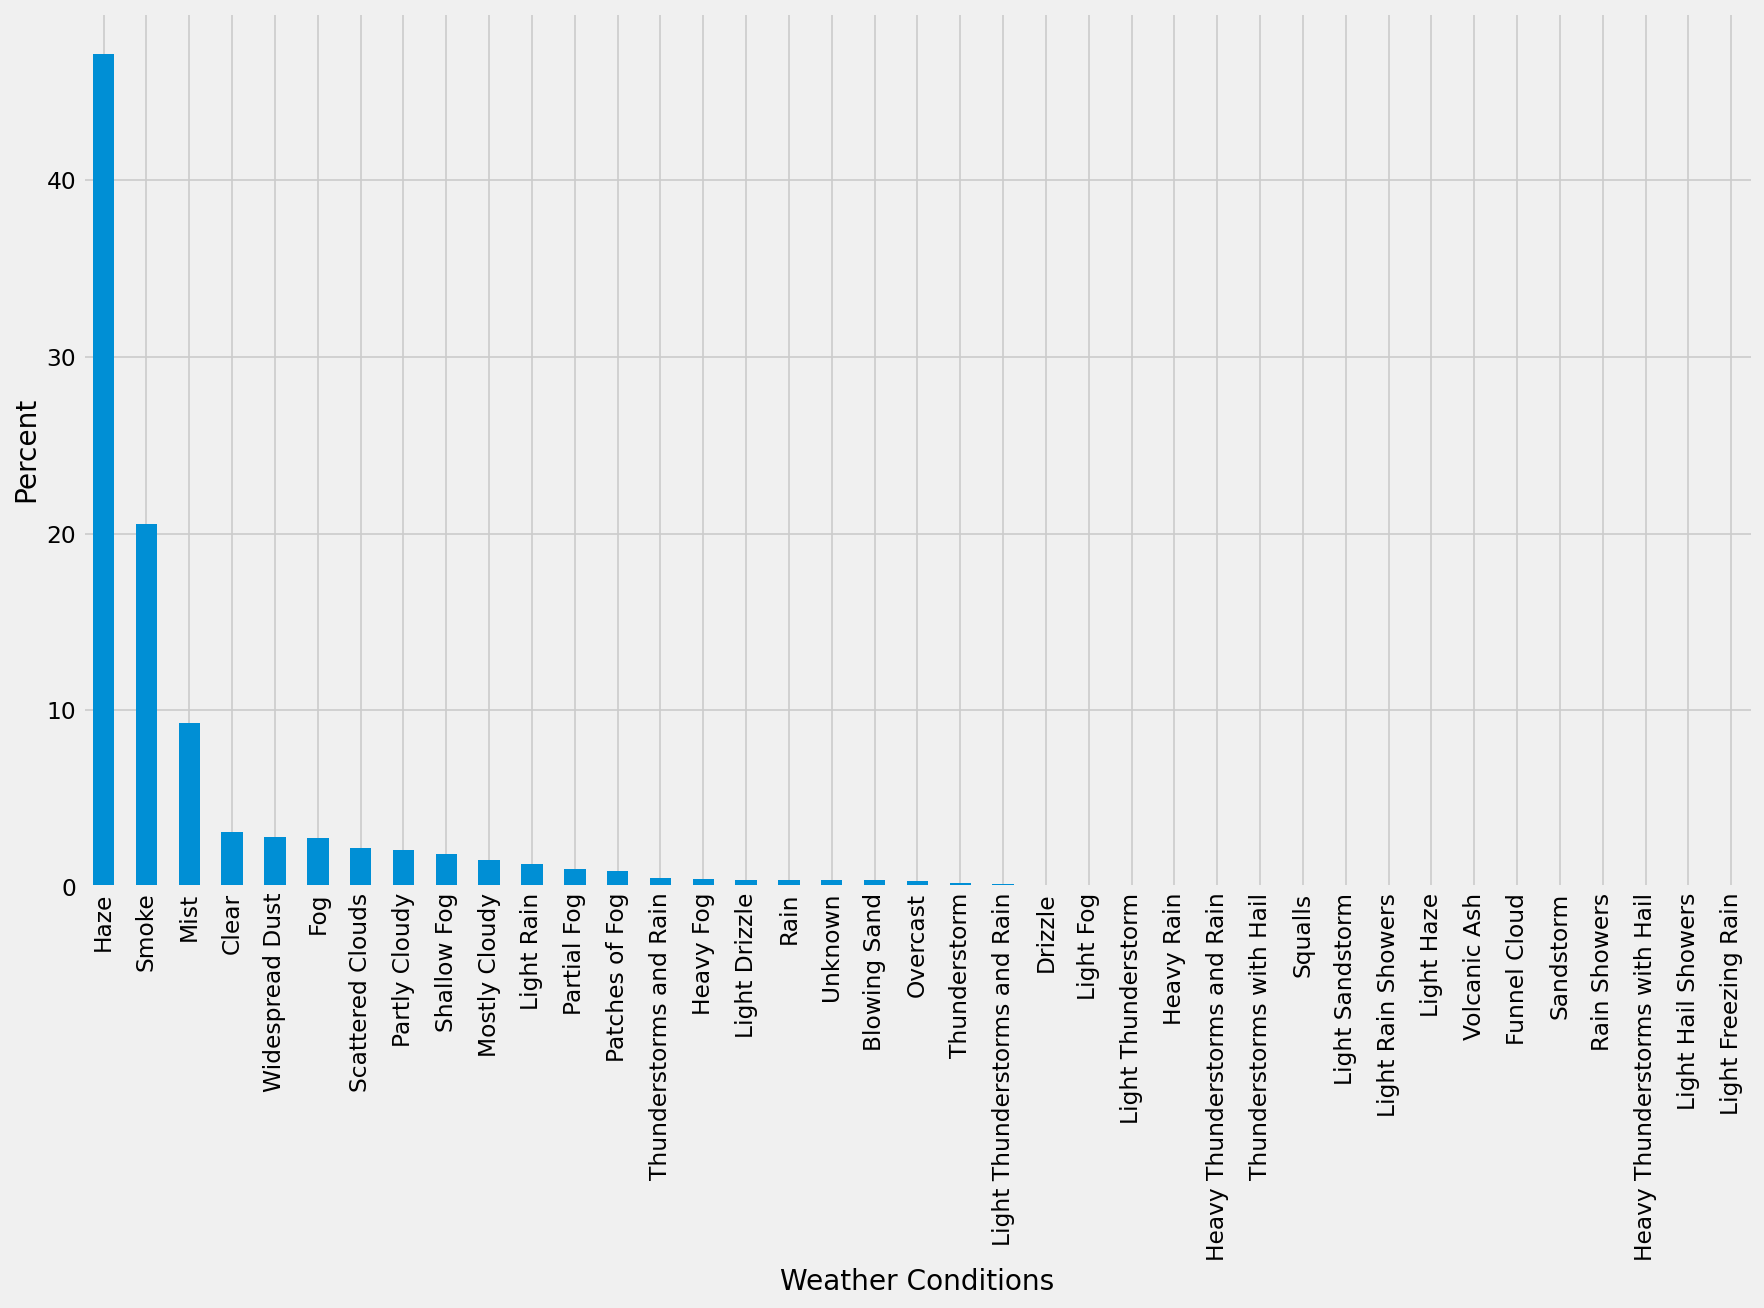

In [69]:
weather_condition = (weather_df.condition.value_counts()/(weather_df.condition.value_counts().sum()))*100
weather_condition.plot.bar(figsize=(16,9))
plt.xlabel('Weather Conditions')
plt.ylabel('Percent')

array([<AxesSubplot:xlabel='datetime_utc'>,
       <AxesSubplot:xlabel='datetime_utc'>], dtype=object)

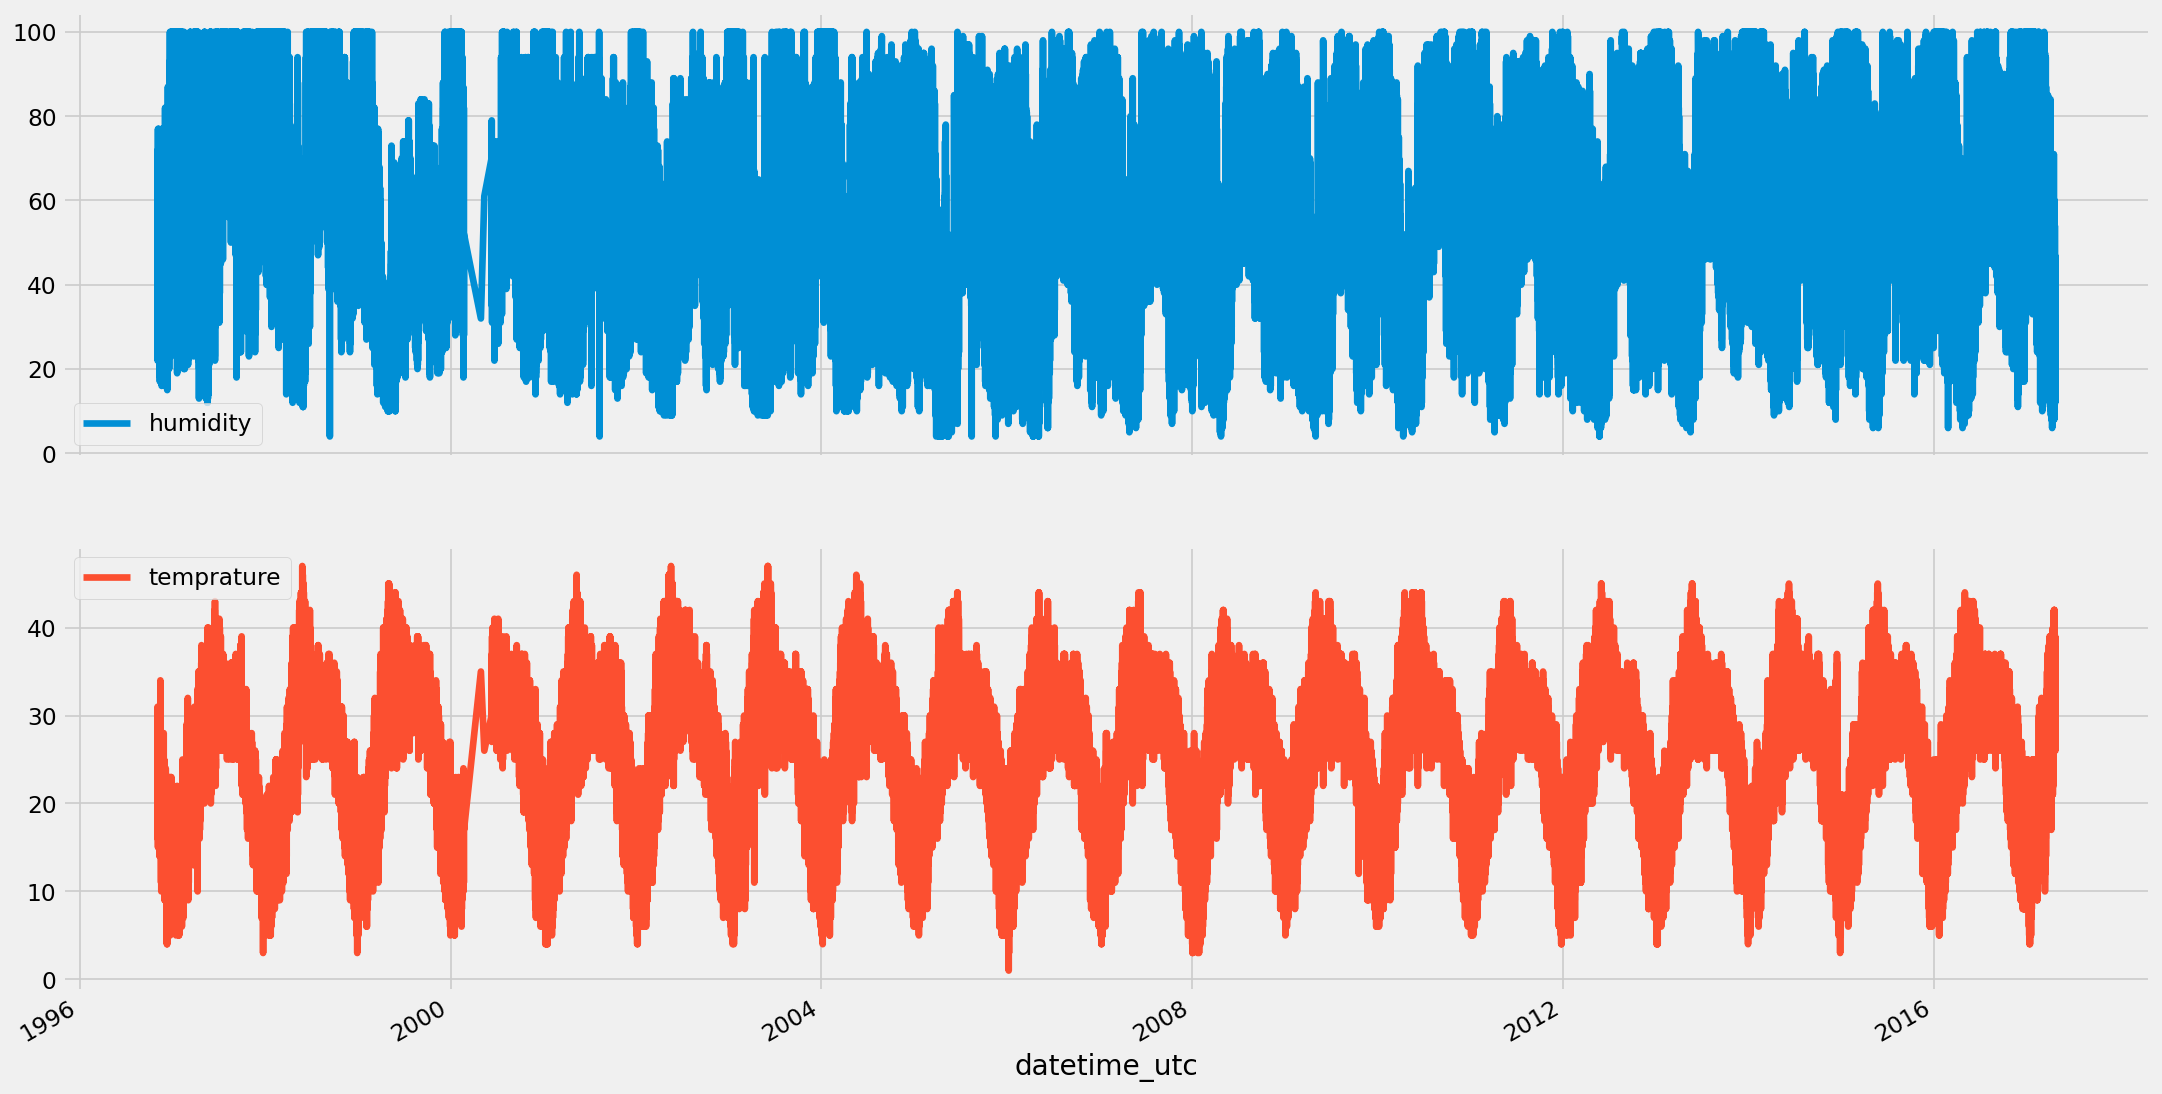

In [70]:
weather_df.plot(subplots=True, figsize=(20,12))

In [ ]:
# Der Zeitraum ist sehr umfangreich und ermöglicht und nur eine wenig spezifische Information - Fokus: 2015-2016

array([<AxesSubplot:xlabel='datetime_utc'>,
       <AxesSubplot:xlabel='datetime_utc'>], dtype=object)

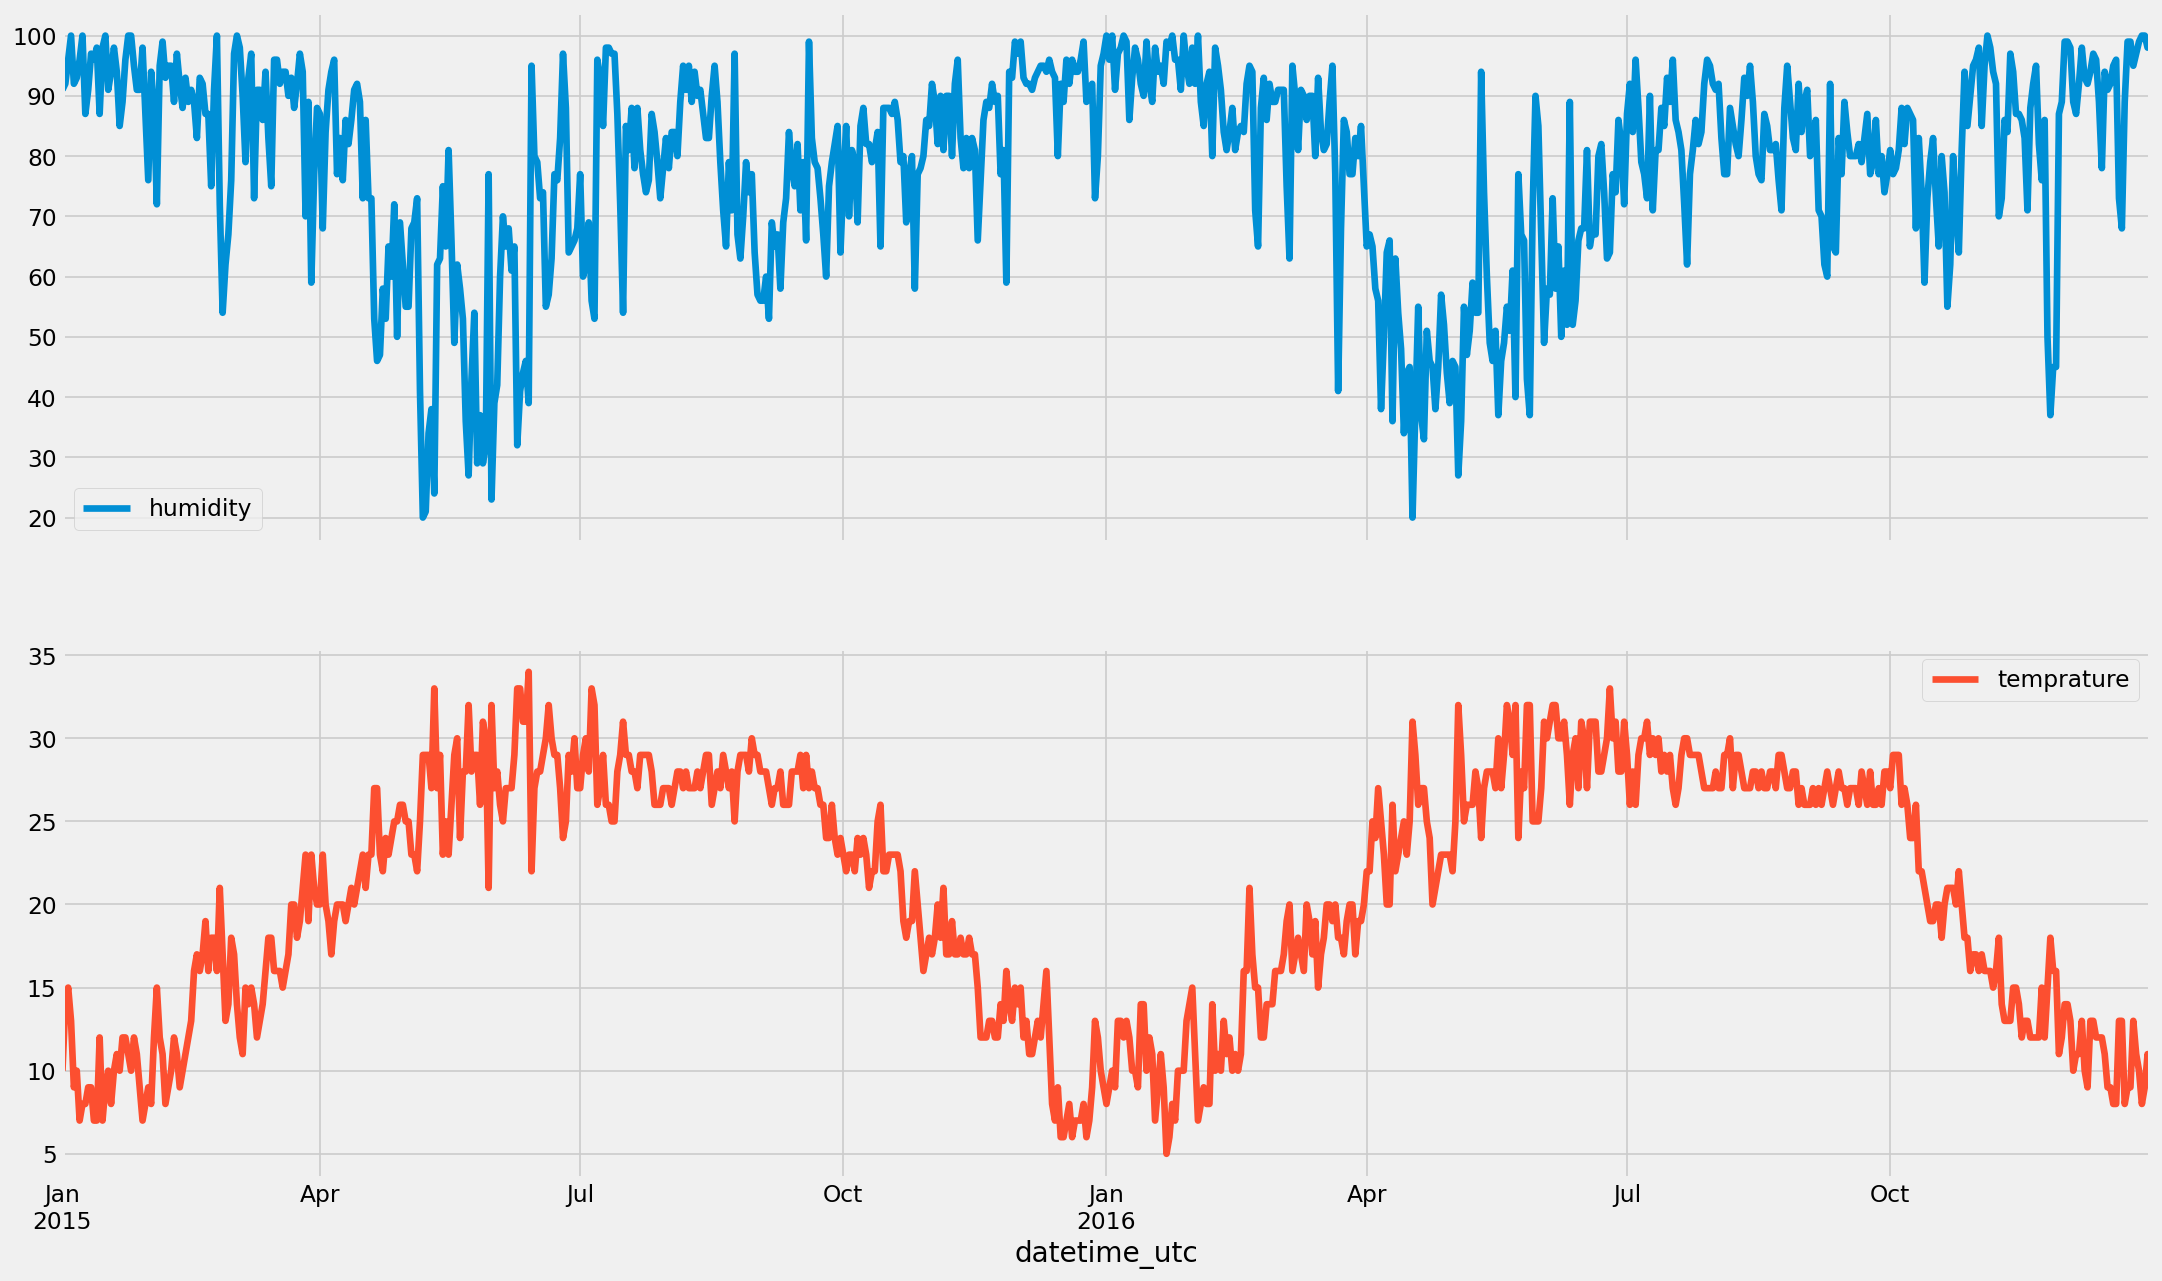

In [71]:
weather_df['2015':'2016'].resample('D').fillna(method='pad').plot(subplots=True, figsize=(20,12))

In [ ]:
# Wie nennt man diese Art von Verlauf? Erkennen Sie einen Trend?

In [ ]:
# Wir testen die Stationarität: 

# Stationarität ist eine der bedeutendsten Eigenschaften stochastischer Prozesse 
# in der Zeitreihenanalyse. Mit der Stationarität erhält man Eigenschaften, die nicht nur für einzelne Zeitpunkte
# gelten, sondern Invarianzen über die Zeit hinweg sind.

In [72]:
train_df = weather_df['2000':'2015'].resample('M').mean().fillna(method='pad')
train_df.drop(columns='humidity', axis=1, inplace=True)
test_df = weather_df['2016':'2017'].resample('M').mean().fillna(method='pad')
test_df.drop(columns='humidity', axis=1, inplace=True)

In [73]:
def plot_rolling_mean_std(ts):
    rolling_mean = ts.rolling(12).mean()
    rolling_std = ts.rolling(12).std()
    plt.figure(figsize=(22,10))

    plt.plot(ts, label='Actual Mean')
    plt.plot(rolling_mean, label='Rolling Mean')
    plt.plot(rolling_std, label = 'Rolling Std')
    plt.xlabel("Date")
    plt.ylabel("Mean Temperature")
    plt.title('Rolling Mean & Rolling Standard Deviation')
    plt.legend()
    plt.show()

In [74]:
def perform_dickey_fuller_test(ts):
    result = adfuller(ts, autolag='AIC')
    print('Test statistic: ' , result[0])
    print('Critical Values:' ,result[4])

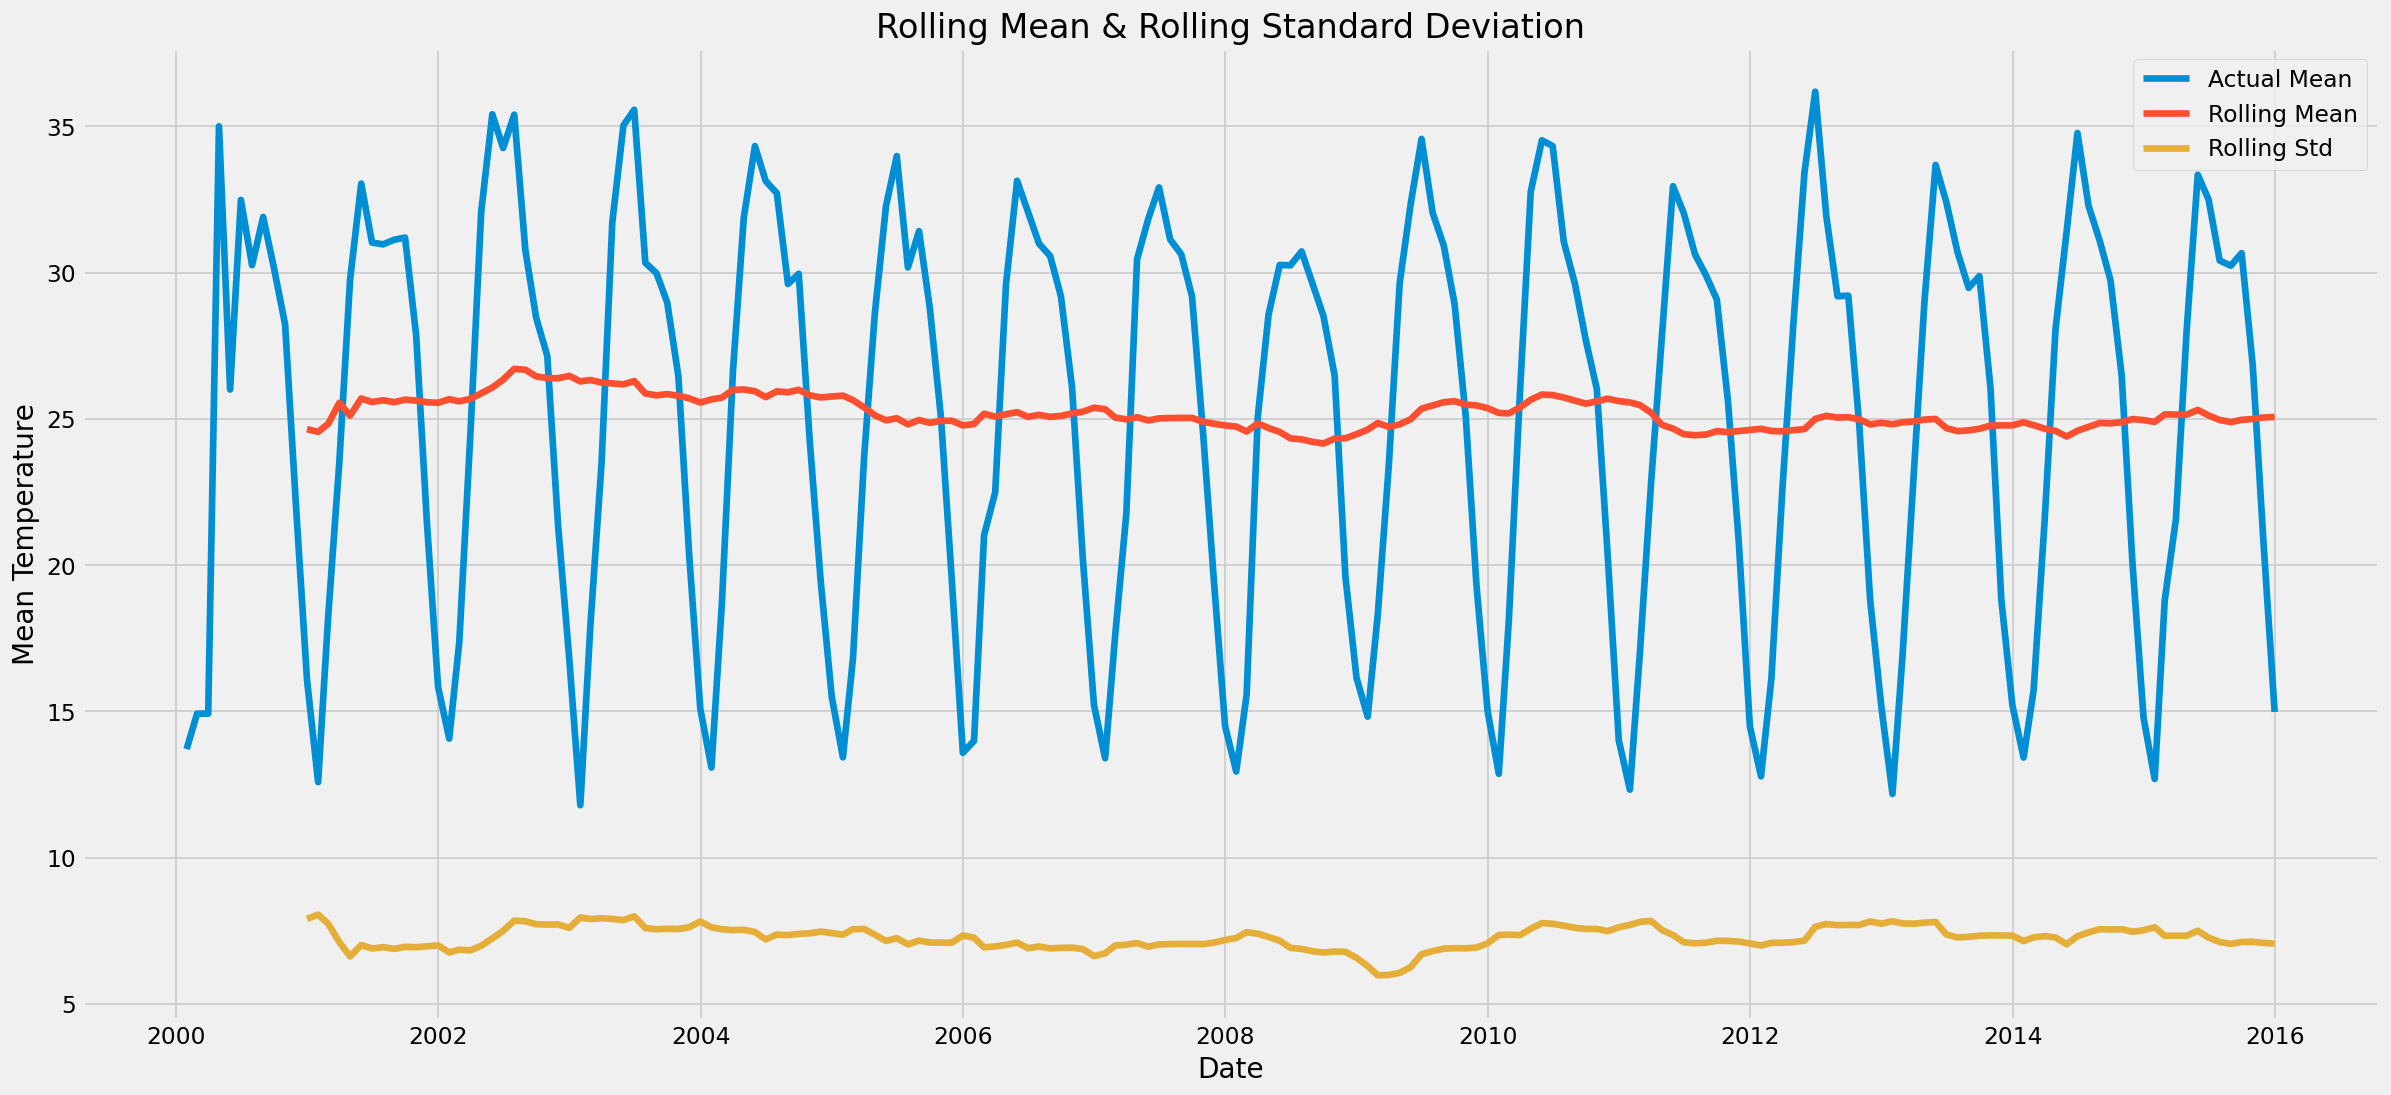

Test statistic:  -2.1269952502980454
Critical Values: {'1%': -3.4674201432469816, '5%': -2.877826051844538, '10%': -2.575452082332012}


In [75]:
plot_rolling_mean_std(train_df.temprature)
perform_dickey_fuller_test(train_df.temprature)

In [ ]:
# Wir haben eine stationäre Zeitreihe und wir brauchen daher keine ergänzenden Methoden (Differencing oder Decomposing)

In [ ]:
# Wir starten mit der ARIMA (Auto regressive integrated moving average)

# acf = autocorrelation function: es wird die Korrelation zweier aufeinenanderfolgender (verzögerter) Versionen gemessen
# eine Verzögerung von 2 bedeutet etwa: Korrelation zwischen t1...t2 mit den Reihen t1-4...t2-4

# pacf = partial autocorrelation function

C:\Users\jonas\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


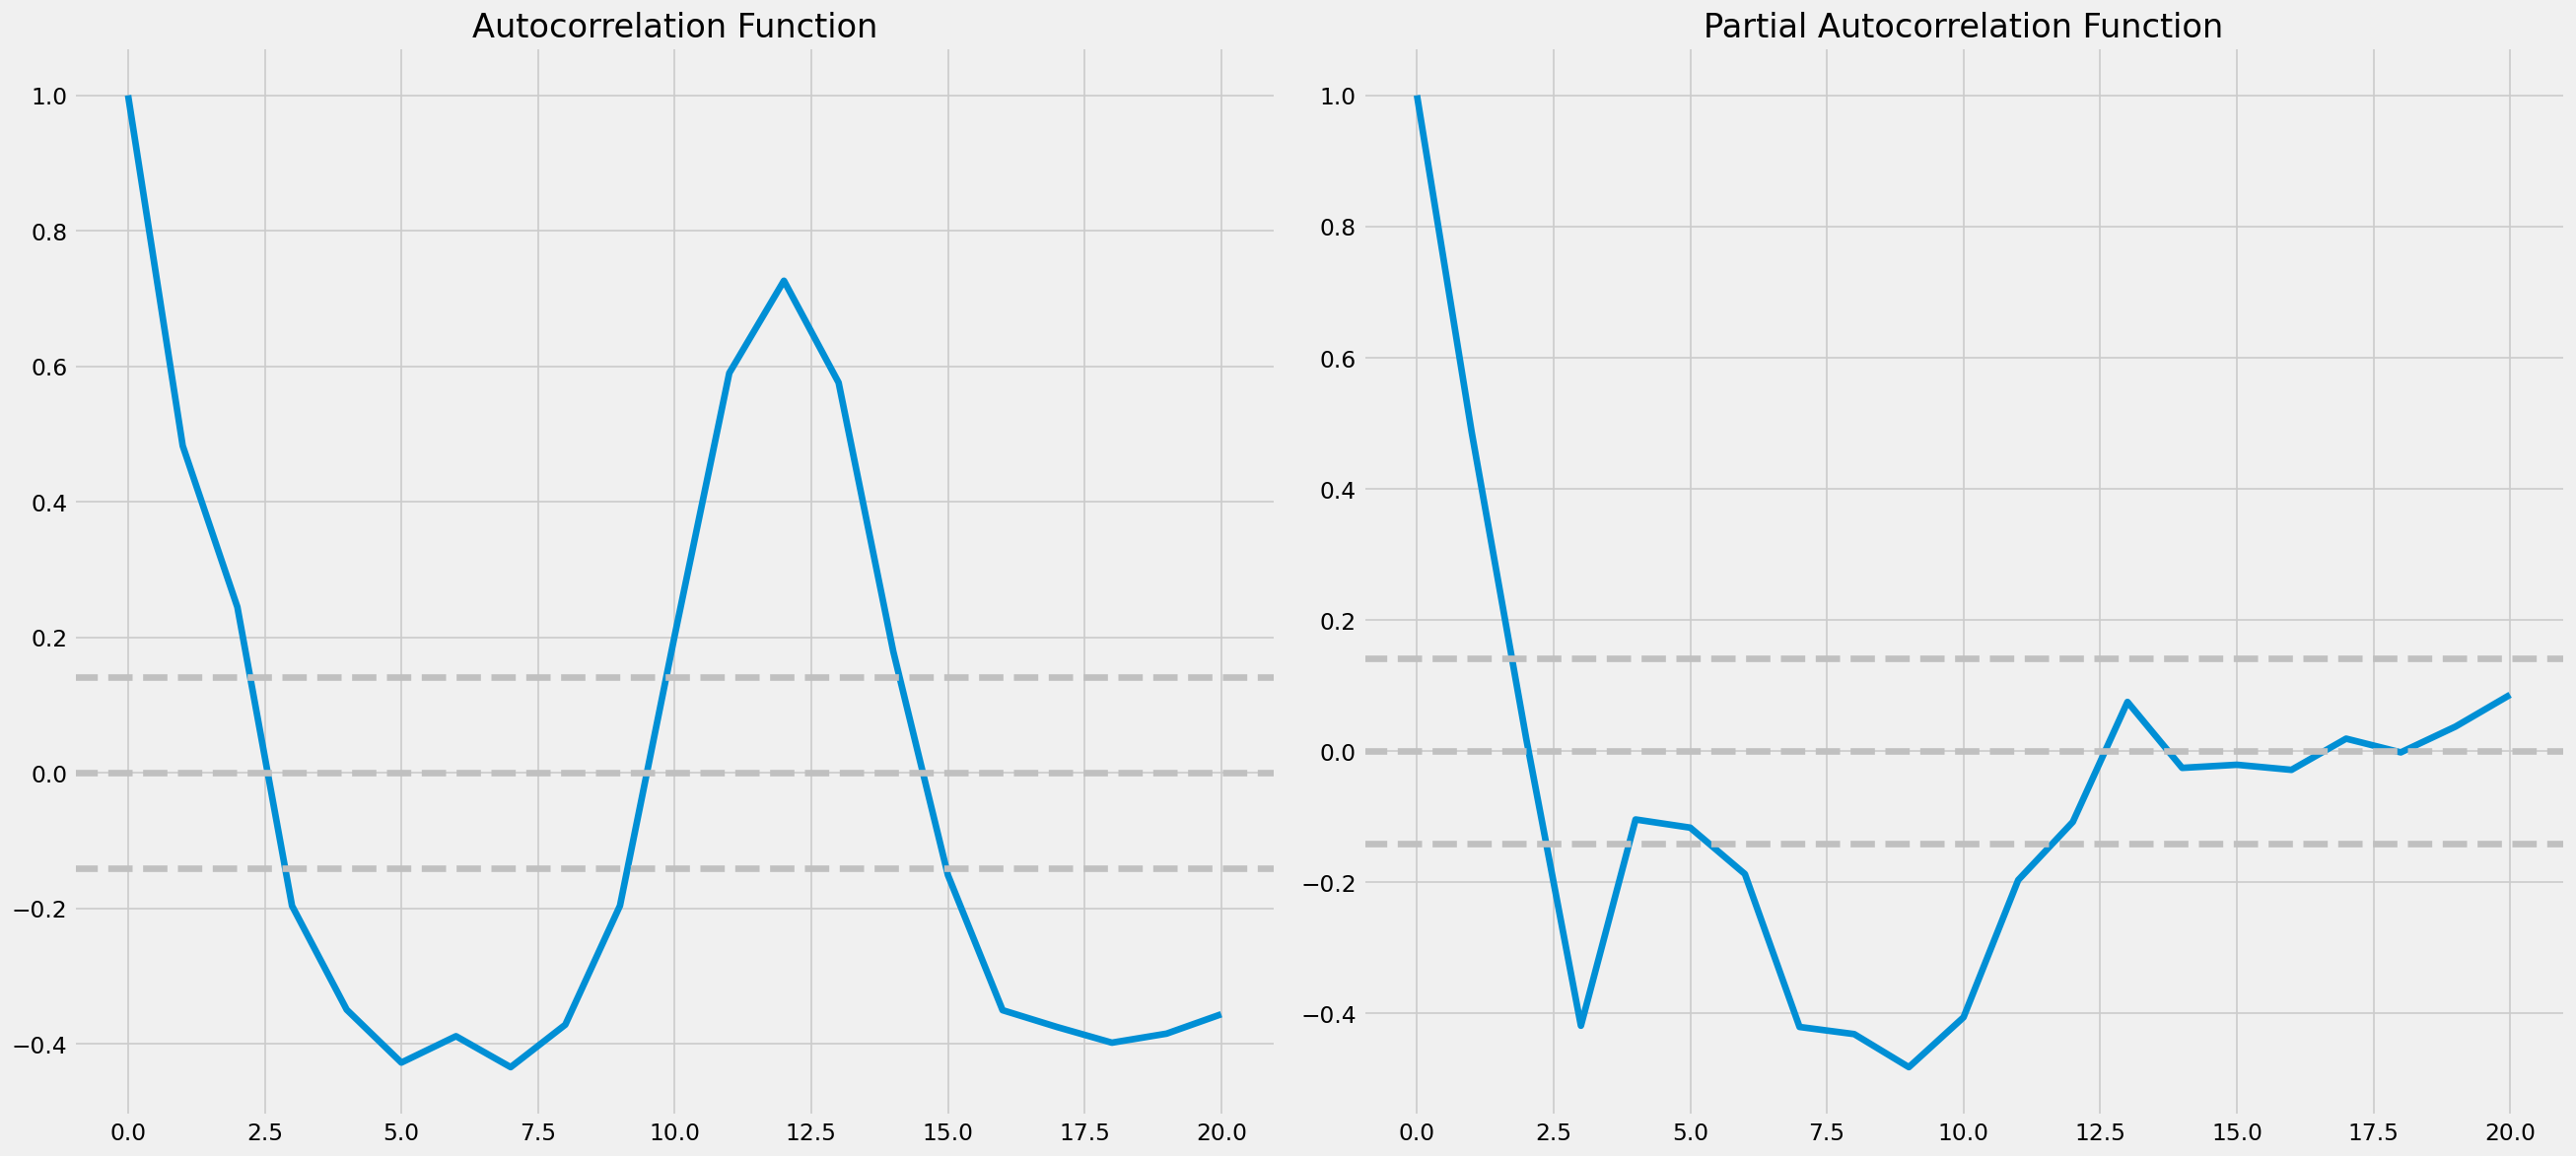

In [76]:
acf_lag = acf(train_df.diff().dropna().values, nlags=20)
pacf_lag = pacf(train_df.diff().dropna().values, nlags=20, method='ols')

plt.figure(figsize=(22,10))

plt.subplot(121)
plt.plot(acf_lag)
plt.axhline(y=0,linestyle='--',color='silver')
plt.axhline(y=-1.96/np.sqrt(len(train_df.diff().values)),linestyle='--',color='silver')
plt.axhline(y=1.96/np.sqrt(len(train_df.diff().values)),linestyle='--',color='silver')
plt.title("Autocorrelation Function")

plt.subplot(122)
plt.plot(pacf_lag)
plt.axhline(y=0,linestyle='--',color='silver')
plt.axhline(y=-1.96/np.sqrt(len(train_df.diff().values)),linestyle='--',color='silver')
plt.axhline(y=1.96/np.sqrt(len(train_df.diff().values)),linestyle='--',color='silver')
plt.title("Partial Autocorrelation Function")
plt.tight_layout()

In [ ]:
# Was bedeuten die grau-gestrichelten Linien? Wir brauchen sie als Input für das ARIMA Modell 
# p = der Punkt im PACF, der das obere Konfidenzintervall schneidet (2)
# q = der Punkt im ACF, der das obere Konfidenzintervall schneidet (2)
# d = 0

In [77]:
model = ARIMA(train_df.values, order=(2,0,2))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  192
Model:                     ARMA(2, 2)   Log Likelihood                -454.355
Method:                       css-mle   S.D. of innovations              2.552
Date:                Sun, 23 Jan 2022   AIC                            920.709
Time:                        17:00:31   BIC                            940.254
Sample:                             0   HQIC                           928.625
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         25.1917      0.119    211.045      0.000      24.958      25.426
ar.L1.y        1.6785      0.024     69.834      0.000       1.631       1.726
ar.L2.y       -0.9519      0.023    -41.164      0.0

C:\Users\jonas\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


In [ ]:
# tatsächlicher Verlauf vs. gefitteter Verlauf

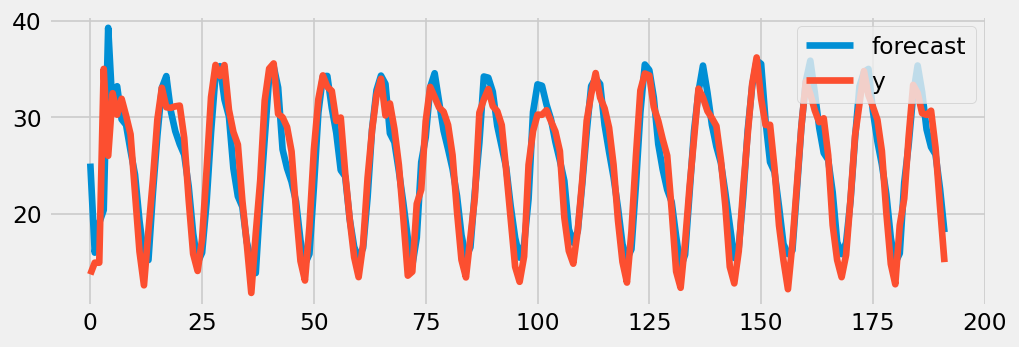

In [78]:
model_fit.plot_predict(dynamic=False)
plt.show()

In [ ]:
# finaler Forecast: tatsächlicher Wert, prädizierter Wert, Konfidenzintervall

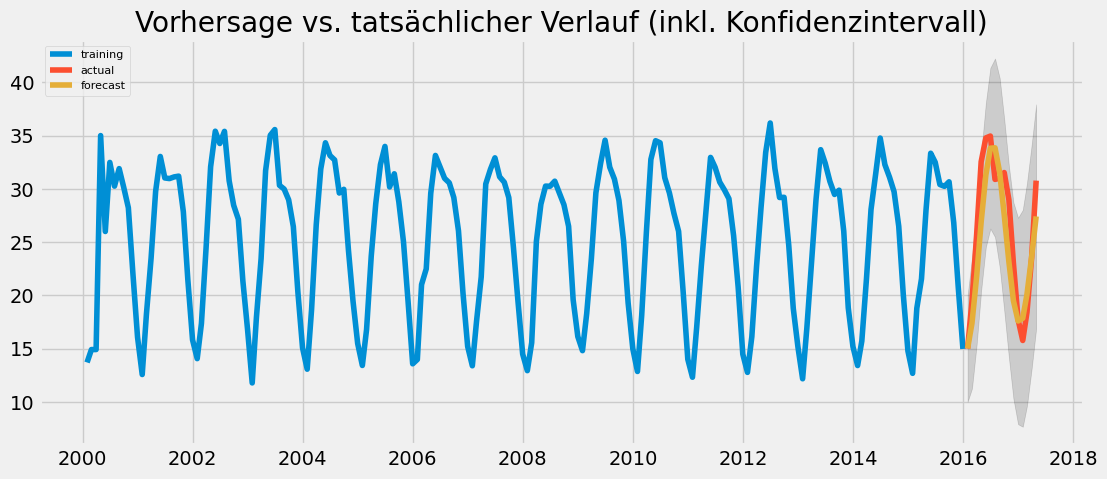

In [79]:
# # Forecast
fc, se, conf = model_fit.forecast(16, alpha=0.05)  # 95% conf

# print(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_df.index)
lower_series = pd.Series(conf[:, 0], index=test_df.index)
upper_series = pd.Series(conf[:, 1], index=test_df.index)

# # Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_df, label='training')
plt.plot(test_df, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Vorhersage vs. tatsächlicher Verlauf (inkl. Konfidenzintervall)')
plt.legend(loc='upper left', fontsize=8)
plt.show()
# test_df.index